# Projeto Machine Learning

[Explicação do projeto]

[Motivação]

[Índice]

*Sumario*<br/><br/>1 - [Importando Libs](#1---Importando-Libs)<br/>2 - [Apagando os avisos do notebook](#2---Apagando-os-avisos-do-notebook)<br/>3 - [Carregando Dataset](#3---Carregando-Dataset)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 - [Testando os audios](#3.1---Testando-os-audios)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 - [Separando Treinamento e Teste](#3.2---Separando-Treinamento-e-Teste)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 - [Verificando a distribuição de treinamento e teste entre os estilos musicais](#3.2.1---Verificando-a-distribuição-de-treinamento-e-teste-entre-os-estilos-musicais)<br/>4 - [Extração de Features](#4---Extração-de-Features)<br/>5 - [Cenário I](#5---Cenário-I)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1 - [Analisando cada extração de feature e os parâmetros utilizados nos modelos](#5.1---Analisando-cada-extração-de-feature-e-os-parâmetros-utilizados-nos-modelos)

# 1 - Importando Libs

In [1]:
# Libs matplotlib, numpy and pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Lib librosa
import librosa
import librosa.display

# Lib OS
from os import listdir
from os.path import isfile, join, exists

# Lib ipwidgets
from ipywidgets import interact, IntSlider, interact_manual
import ipywidgets as widgets



# Lib IPtyhon
from IPython import display as ipd

# Lib glob
import glob

# Lib sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split

# Lib keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers

from collections import defaultdict

# 2 - Apagando os avisos do notebook

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 3 - Carregando Dataset

Baixar todo o [dataset](https://www.kaggle.com/carlthome/gtzan-genre-collection) (genre/) e colocar na mesma pasta do projeto.

In [3]:
def import_signal(path):
    
    # Test if path exists
    if( exists(path) == False ):
        print("Path does not exist, download from https://www.kaggle.com/carlthome/gtzan-genre-collection")
        return 0, 0
    
    # Load files woth glob
    files = glob.glob(path + '*.au')
    audios = []
    
    # Load audio files with sample rate 22050 Hz
    for file in files: 
        s, sr = librosa.core.load(file, sr=22050)
        audios.append(s)
        
    # Return audio vector and sample rate
    return audios, sr

Iremos considerar os seguintes rótulos para cada estilo:

    * Popular  =>  y=0 e y2=0
    * Clássico =>  y=1 e y2=0
    * Jazz     =>  y=2 e y2=1
    * Rock     =>  y=3 e y2=1
    
Isso porque y equivale ao rótulo do primeiro cenário, no qual temos apenas uma SVM e 4 possíveis saídas. Já y2 é usado no segundo cenário nas primeiras SVMs, as quais são utilizadas para separar os estilos popular e clássico dos estilos jazz e rock.

In [4]:
def get_audios_df():
    
    cont = 0
    audios_dict = defaultdict(list)
    for musical_genre in ['pop', 'classical', 'jazz', 'rock']:

        audios, sr =  import_signal(f'genres/{musical_genre}/')
        audios_dict[musical_genre].append(audios)
        
        audios_df_aux = pd.DataFrame([[x] for x in audios], columns=['x'])

        genre_dict_y = {'pop':0, 'classical':1, 'jazz':2, 'rock':3}
        genre_dict_y2 = {'pop':0, 'classical':0, 'jazz':1, 'rock':1}

        audios_df_aux['y'] = genre_dict_y[f'{musical_genre}']
        audios_df_aux['y2'] = genre_dict_y2[f'{musical_genre}']
        
        if cont == 0:
            audios_df = audios_df_aux
        else:
            audios_df = pd.concat([audios_df, audios_df_aux])
        cont+=1
        
    return audios_df, audios_dict, sr

In [5]:
audios_df, audios_dict, sr = get_audios_df()
audios_df = audios_df.sample(frac=1).reset_index(drop=True) # shuffle

print(f'Rows: {len(audios_df)}')
audios_df.head(2)

Rows: 400


x  y  y2
0  [0.023345947, 0.028686523, 0.027038574, 0.0279...  1   0
1  [0.007080078, 0.0119018555, 0.012329102, 0.014...  1   0

## 3.1 - Testando os audios

In [6]:
global chosed_musical_genre
chosed_musical_genre = 'pop'

global chosed_file
chosed_file = 0

In [7]:
w_dropdown = widgets.Dropdown(options=['pop', 'classical', 'jazz', 'rock'],
                              value='pop', description='Genero:', disabled=False)

output_dropdown = widgets.Output()

def on_change_dropdown(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global chosed_musical_genre
        chosed_musical_genre = change['new']
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([14])'))

w_dropdown.observe(on_change_dropdown)
display(w_dropdown, output_dropdown)

Dropdown(description='Genero:', options=('pop', 'classical', 'jazz', 'rock'), value='pop')

Output()

In [8]:
w_int_slider = widgets.IntSlider(value=0, min=0, max=99, step=1,
                                 description='File:', disabled=False,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='d')

output_int_slider = widgets.Output()

def on_change_int_slider(change):
    with output_int_slider:
        global chosed_file
        chosed_file = change['new']
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([14])'))

w_int_slider.observe(on_change_int_slider, 'value')
display(w_int_slider, output_int_slider)

IntSlider(value=0, continuous_update=False, description='File:', max=99)

Output()

In [9]:
ipd.Audio(audios_dict[chosed_musical_genre][0][chosed_file], rate=sr)

## 3.2 - Separando Treinamento e Teste

In [10]:
msk = np.random.rand(len(audios_df)) < 0.8
train = audios_df[msk]
test = audios_df[~msk]

print(f'Rows train:{len(train)}')
print(f'Rows test:{len(test)}')

Rows train:316
Rows test:84


### 3.2.1 - Verificando a distribuição de treinamento e teste entre os estilos musicais

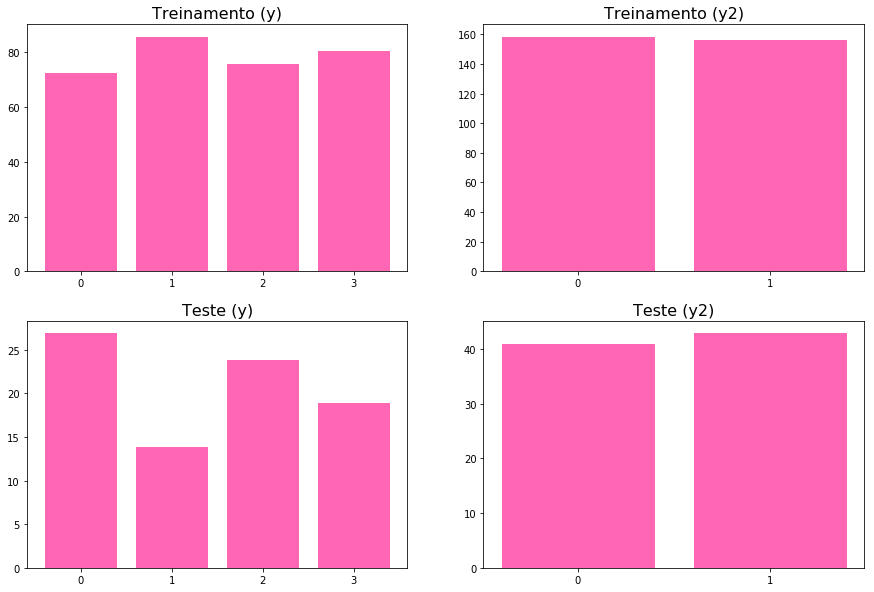

In [11]:
bins_y = np.sort(train['y'].unique())
bins_y2 = np.sort(train['y2'].unique())

fig, axs = plt.subplots(2, 2, figsize=(15,10))

axs[0, 0].bar(bins_y, np.histogram(train['y'], bins=len(bins_y))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[0, 0].set_xticks(bins_y)
axs[0, 0].set_title('Treinamento (y)', fontsize=16)

axs[0, 1].bar(bins_y2, np.histogram(train['y2'], bins=len(bins_y2))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[0, 1].set_xticks(bins_y2)
axs[0, 1].set_title('Treinamento (y2)', fontsize=16)

axs[1, 0].bar(bins_y, np.histogram(test['y'], bins=len(bins_y))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[1, 0].set_xticks(bins_y)
axs[1, 0].set_title('Teste (y)', fontsize=16)

axs[1, 1].bar(bins_y2, np.histogram(test['y2'], bins=len(bins_y2))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[1, 1].set_xticks(bins_y2)
axs[1, 1].set_title('Teste (y2)', fontsize=16)

plt.show()

# 4 - Extração de Features

In [12]:
def mfcc_feature_extract(x_column, sr):
    mfcc_list = []
    for x in x_column:
        mfcc_flatten = np.array(librosa.feature.mfcc(y=x, sr=sr)).flatten()
        zeros = np.zeros((26280 - len(mfcc_flatten))) # fazemos isso pois, para cada x temos diferentes
                                                      # tamanhos de mfcc - sendo o maximo=26280
        mfcc_list.append(np.concatenate((mfcc_flatten, zeros), axis=0))
    return mfcc_list

def mel_spect_feature_extract(x_column, sr):
    mel_spect_list = []
    for x in x_column:
        mel_spect_flatten = np.array(librosa.feature.melspectrogram(y=x, sr=sr)).flatten()
        zeros = np.zeros((168192 - len(mel_spect_flatten))) # fazemos isso pois, para cada x temos diferentes
                                                           # tamanhos de mel_spect - sendo o maximo=168192
        mel_spect_list.append(np.concatenate((mel_spect_flatten, zeros), axis=0))
    return mel_spect_list

def lpc_feature_extract(x_column, order=6):
    lpc_list = []
    for x in x_column:
        lpc = librosa.lpc(x, order=order)
        lpc_list.append(lpc)
    return lpc_list

In [13]:
def feature_extract(df, sr):
    
    # MFCC
    df['mfcc'] = mfcc_feature_extract(df['x'], sr)
    
    # LPC
    df['lpc'] = lpc_feature_extract(df['x'], order=6)
    
    # Mel Spectogram
    df['mel_spect'] = mel_spect_feature_extract(df['x'], sr)
    
    # MFCC + LPC
    df['mfcc_lpc'] = (
        df['mfcc'].apply(lambda x: x.tolist()) + 
        df['lpc'].apply(lambda x: x.tolist())
    )
    
    # Mel Spectogram + LPC
    df['mel_spect_lpc'] = (
        df['mel_spect'].apply(lambda x: x.tolist()) + 
        df['lpc'].apply(lambda x: x.tolist())
    )
    
    return df 

In [14]:
# Train
train = feature_extract(train, sr)
train.head(2)

x  y  y2  \
0  [0.023345947, 0.028686523, 0.027038574, 0.0279...  1   0   
1  [0.007080078, 0.0119018555, 0.012329102, 0.014...  1   0   

                                                mfcc  \
0  [-157.8610076904297, -167.13613891601562, -182...   
1  [-377.37750244140625, -388.97589111328125, -40...   

                                                 lpc  \
0  [1.0, -2.2621884, 1.9953386, -0.8964555, 0.245...   
1  [1.0, -2.758797, 3.2598617, -2.6274524, 1.9476...   

                                           mel_spect  \
0  [0.6367231607437134, 0.31213951110839844, 0.11...   
1  [0.021097417920827866, 0.017338905483484268, 0...   

                                            mfcc_lpc  \
0  [-157.8610076904297, -167.13613891601562, -182...   
1  [-377.37750244140625, -388.97589111328125, -40...   

                                       mel_spect_lpc  
0  [0.6367231607437134, 0.31213951110839844, 0.11...  
1  [0.021097417920827866, 0.017338905483484268, 0...

In [15]:
# Test
test = feature_extract(test, sr)
test.head(2)

x  y  y2  \
2  [0.122039795, 0.22442627, 0.19665527, 0.171508...  2   1   
3  [0.07925415, 0.059326172, 0.03930664, 0.033081...  3   1   

                                                mfcc  \
2  [-122.11055755615234, -164.09036254882812, -26...   
3  [-79.6927719116211, -78.33087158203125, -84.67...   

                                                 lpc  \
2  [1.0, -2.6250784, 3.1437635, -2.6603837, 1.882...   
3  [1.0, -1.2454756, 0.5987723, -0.423704, 0.4051...   

                                           mel_spect  \
2  [1.1510541439056396, 0.2909896671772003, 0.017...   
3  [6.624444961547852, 1.464979887008667, 0.11035...   

                                            mfcc_lpc  \
2  [-122.11055755615234, -164.09036254882812, -26...   
3  [-79.6927719116211, -78.33087158203125, -84.67...   

                                       mel_spect_lpc  
2  [1.1510541439056396, 0.2909896671772003, 0.017...  
3  [6.624444961547852, 1.464979887008667, 0.11035...

# 5 - Cenário I

* Usando uma rede SVM de apenas uma cama para reconhecer os 4 tipos musicais

In [50]:
def get_first_scenario_score_and_model(train, test, feature_ex='lpc', feature_ex2='mfcc_lpc', 
                                       two_features_ex=False, return_model=False, plot=False,
                                       degree=3, gamma=0.7, C=1.0):
    
    if two_features_ex:
        model = svm.SVC(kernel='poly', degree=degree, C=C)
        model.fit(train[f'{feature_ex2}'].to_list(), train['y'].to_list())

        train_score = (
            model.score(train[f'{feature_ex2}'].to_list(), train['y'].to_list())
        )

        test_score = (
            model.score(test[f'{feature_ex2}'].to_list(), test['y'].to_list())
        )
        
    else:
        if feature_ex=='lpc':
            model = svm.SVC(kernel='rbf', gamma=gamma, C=C)
        else:
            model = svm.SVC(kernel='poly', degree=degree, C=C)
            
        model.fit(train[f'{feature_ex}'].to_list(), train['y'].to_list())

        train_score = (
            model.score(train[f'{feature_ex}'].to_list(), train['y'].to_list())
        )

        test_score = (
            model.score(test[f'{feature_ex}'].to_list(), test['y'].to_list())
        )
    
    if return_model:
         return model
        
    return train_score, test_score
    
    
#     if plot:
        
    
        

## 5.1 - Analisando cada extração de feature e os parâmetros utilizados nos modelos

### 5.1.1 - MFCC

In [35]:
for degree in np.arange(1,7,1):
    print(f'Results with degree={degree}')
    
    train_score, test_score = get_first_scenario_score_and_model(train, test, 
                                                                 feature_ex='mfcc', 
                                                                 degree=degree)
    
    print('Train accuracy: {:.1%}'.format(train_score))
    print('Test accuracy: {:.1%}'.format(test_score))
    print('\n')

Results with degree=1
Train accuracy: 100.0%
Test accuracy: 84.5%


Results with degree=2
Train accuracy: 100.0%
Test accuracy: 86.9%


Results with degree=3
Train accuracy: 100.0%
Test accuracy: 82.1%


Results with degree=4
Train accuracy: 100.0%
Test accuracy: 79.8%


Results with degree=5
Train accuracy: 100.0%
Test accuracy: 70.2%


Results with degree=6
Train accuracy: 100.0%
Test accuracy: 63.1%




Melhor resultado: degree=2

In [ ]:
# model, train_score, test_score = get_first_scenario_score_and_model(train, test, feature_ex='mfcc', 
#                                                              degree=2, return_model=True)

# print('Train accuracy: {:.1%}'.format(train_score))
# print('Test accuracy: {:.1%}'.format(test_score))

In [ ]:
# support_vectors = model.support_vectors_

# plt.scatter(train['y'])
# plt.scatter(model.predict(train['mfcc'].to_list()))
# # plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
# plt.title('Linearly separable data with support vectors')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.show()

In [ ]:
# # plot the decision function
# ax = plt.gca()
# xlim = ax.get_xlim()
# ylim = ax.get_ylim()

# # create grid to evaluate model
# xx = np.linspace(xlim[0], xlim[1], 30)
# yy = np.linspace(ylim[0], ylim[1], 30)
# YY, XX = np.meshgrid(yy, xx)
# xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Z = clf.decision_function(xy).reshape(XX.shape)

# # plot decision boundary and margins
# ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
#            linestyles=['--', '-', '--'])
# # plot support vectors
# ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
#            linewidth=1, facecolors='none', edgecolors='k')
# plt.show()

### 5.1.2 - Mel Spectogram

In [36]:
for degree in np.arange(1,7,1):
    print(f'Results with degree={degree}')
    
    train_score, test_score = get_first_scenario_score_and_model(train, test, 
                                                                 feature_ex='mel_spect', 
                                                                 degree=degree)
    
    print('Train accuracy: {:.1%}'.format(train_score))
    print('Test accuracy: {:.1%}'.format(test_score))
    print('\n')

Results with degree=1
Train accuracy: 100.0%
Test accuracy: 73.8%


Results with degree=2
Train accuracy: 100.0%
Test accuracy: 65.5%


Results with degree=3
Train accuracy: 100.0%
Test accuracy: 54.8%


Results with degree=4
Train accuracy: 100.0%
Test accuracy: 46.4%


Results with degree=5
Train accuracy: 100.0%
Test accuracy: 46.4%


Results with degree=6
Train accuracy: 100.0%
Test accuracy: 45.2%




Melhor resultado: degree=1

In [ ]:
# train_score, test_score = get_first_scenario_score_and_model(train, test, feature_ex='mel_spect', 
#                                                              degree=1, plot=True)

# print('Train accuracy: {:.1%}'.format(train_score))
# print('Test accuracy: {:.1%}'.format(test_score))

### 5.1.3 - LPC

In [37]:
for gamma in np.arange(0.5,2,0.1):
    print(f'Results with gamma={gamma}')
    
    train_score, test_score = get_first_scenario_score_and_model(train, test, 
                                                                 feature_ex='lpc', 
                                                                 gamma=gamma)
    
    print('Train accuracy: {:.1%}'.format(train_score))
    print('Test accuracy: {:.1%}'.format(test_score))
    print('\n')

Results with gamma=0.5
Train accuracy: 73.1%
Test accuracy: 63.1%


Results with gamma=0.6
Train accuracy: 73.7%
Test accuracy: 61.9%


Results with gamma=0.7
Train accuracy: 72.8%
Test accuracy: 61.9%


Results with gamma=0.7999999999999999
Train accuracy: 73.1%
Test accuracy: 61.9%


Results with gamma=0.8999999999999999
Train accuracy: 73.7%
Test accuracy: 61.9%


Results with gamma=0.9999999999999999
Train accuracy: 74.7%
Test accuracy: 64.3%


Results with gamma=1.0999999999999999
Train accuracy: 75.6%
Test accuracy: 64.3%


Results with gamma=1.1999999999999997
Train accuracy: 75.6%
Test accuracy: 64.3%


Results with gamma=1.2999999999999998
Train accuracy: 75.9%
Test accuracy: 63.1%


Results with gamma=1.4
Train accuracy: 76.3%
Test accuracy: 63.1%


Results with gamma=1.4999999999999998
Train accuracy: 77.2%
Test accuracy: 63.1%


Results with gamma=1.5999999999999996
Train accuracy: 76.9%
Test accuracy: 64.3%


Results with gamma=1.6999999999999997
Train accuracy: 76.9%
Test

Melhor resultado: gamma=1.5

In [ ]:
# train_score, test_score = get_first_scenario_score_and_model(train, test, feature_ex='lpc', 
#                                                              gamma=1.5, plot=True)

# print('Train accuracy: {:.1%}'.format(train_score))
# print('Test accuracy: {:.1%}'.format(test_score))

### 5.1.4 - MFCC & LPC

In [38]:
for degree in np.arange(1,7,1):
    print(f'Results with degree={degree}')
    
    train_score, test_score = get_first_scenario_score_and_model(train, test, feature_ex2='mfcc_lpc', 
                                                                 two_features_ex=True, degree=degree)
    
    print('Train accuracy: {:.1%}'.format(train_score))
    print('Test accuracy: {:.1%}'.format(test_score))
    print('\n')

Results with degree=1
Train accuracy: 100.0%
Test accuracy: 84.5%


Results with degree=2
Train accuracy: 100.0%
Test accuracy: 86.9%


Results with degree=3
Train accuracy: 100.0%
Test accuracy: 82.1%


Results with degree=4
Train accuracy: 100.0%
Test accuracy: 79.8%


Results with degree=5
Train accuracy: 100.0%
Test accuracy: 70.2%


Results with degree=6
Train accuracy: 100.0%
Test accuracy: 63.1%




Melhor resultado: degree=2

In [ ]:
# train_score, test_score = get_first_scenario_score_and_model(train, test, feature_ex2='mfcc_lpc', 
#                                                              two_features_ex=True, degree=2, 
#                                                              plot=True)

# print('Train accuracy: {:.1%}'.format(train_score))
# print('Test accuracy: {:.1%}'.format(test_score))

### 5.1.5 - Mel spectogram & LPC

In [39]:
for degree in np.arange(1,7,1):
    print(f'Results with degree={degree}')
    
    train_score, test_score = get_first_scenario_score_and_model(train, test, feature_ex2='mel_spect_lpc', 
                                                                 two_features_ex=True, degree=degree)
    
    print('Train accuracy: {:.1%}'.format(train_score))
    print('Test accuracy: {:.1%}'.format(test_score))
    print('\n')

Results with degree=1
Train accuracy: 100.0%
Test accuracy: 73.8%


Results with degree=2
Train accuracy: 100.0%
Test accuracy: 65.5%


Results with degree=3
Train accuracy: 100.0%
Test accuracy: 54.8%


Results with degree=4
Train accuracy: 100.0%
Test accuracy: 46.4%


Results with degree=5
Train accuracy: 100.0%
Test accuracy: 46.4%


Results with degree=6
Train accuracy: 100.0%
Test accuracy: 45.2%




Melhor resultado: degree=1

In [ ]:
# train_score, test_score = get_first_scenario_score_and_model(train, test, feature_ex2='mel_spect_lpc', 
#                                                              two_features_ex=True, degree=1, 
#                                                              plot=True)

# print('Train accuracy: {:.1%}'.format(train_score))
# print('Test accuracy: {:.1%}'.format(test_score))

## 5.2 - Melhor Resultado

RASCUNHO:

Percebemos que entre todas as tentativas acima o MFCC foi o que teve melhor resultado.

### 5.2.1 - Tentativa de predição com o melhor modelo

In [96]:
global chosed_musical_genre_scenario1
chosed_musical_genre_scenario1 = 'pop'

global chosed_file_scenario1
chosed_file_scenario1 = 0

In [97]:
w_dropdown = widgets.Dropdown(options=['pop', 'classical', 'jazz', 'rock'],
                              value='pop', description='Genero:', disabled=False)

output_dropdown = widgets.Output()

def on_change_dropdown(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global chosed_musical_genre_scenario1
        chosed_musical_genre_scenario1 = change['new']
#         ipd.display(ipd.Javascript('IPython.notebook.execute_cells([14])'))

w_dropdown.observe(on_change_dropdown)
display(w_dropdown, output_dropdown)

Dropdown(description='Genero:', options=('pop', 'classical', 'jazz', 'rock'), value='pop')

Output()

In [98]:
w_int_slider = widgets.IntSlider(value=0, min=0, max=99, step=1,
                                 description='File:', disabled=False,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='d')

output_int_slider = widgets.Output()

def on_change_int_slider(change):
    with output_int_slider:
        global chosed_file_scenario1
        chosed_file_scenario1 = change['new']
#         ipd.display(ipd.Javascript('IPython.notebook.execute_cells([14])')) #depois que estiver tudo pronto
                                                                        # a gente define essas proximas 3 celulas

w_int_slider.observe(on_change_int_slider, 'value')
display(w_int_slider, output_int_slider)

IntSlider(value=0, continuous_update=False, description='File:', max=99)

Output()

In [99]:
ipd.Audio(audios_dict[chosed_musical_genre_scenario1][0][chosed_file_scenario1], rate=sr)

In [137]:
audio_test = audios_dict[chosed_musical_genre_scenario1][0][chosed_file_scenario1]

audio_test_mfcc = mfcc_feature_extract([audio_test], sr)[0]

genre_dict = {0: 'popular', 1:'classico',
              2:'jazz', 3:'rock'}

In [138]:
model = get_first_scenario_score_and_model(train, test, feature_ex='mfcc', degree=2, return_model=True)
predicted_musical_genre = genre_dict[model.predict([audio_test_mfcc])[0]]

print(f'\nA música inserida pertence ao estilo musical {predicted_musical_genre}.')


A música inserida pertence ao estilo musical jazz.


# 6 - Cenário II

* Usando 3 redes SVM:
    * SVM1 - separa os estilos pop e classico dos estilos jazz e rock
    * SVM2 - separa o estilo pop do estilo classico
    * SVM3 - separa o estilo jazz do estilo rock

In [18]:
def training_a_model(x, y, feature_ex, gamma, degree, C):
    if feature_ex=='lpc':
        model = svm.SVC(kernel='rbf', gamma=gamma, C=C)
    else:
        model = svm.SVC(kernel='poly', degree=degree, C=C)
        
    model.fit(x, y)
    return model

In [120]:
def get_second_scenario_score_and_models(train, test, feature_ex_svm1='lpc', feature_ex_svm23='mfcc',
                                        degree=2, gamma=1.5, C=1.0, return_models=False):
    
    # SVM1
    model1 = training_a_model(train[f'{feature_ex_svm1}'].to_list(), 
                              train['y2'].to_list(),
                              feature_ex_svm1, gamma, degree, C)
    train['y2_predicted'] = model1.predict(train[f'{feature_ex_svm1}'].to_list())
    
    #SVM2
    train_0 = train[train['y2_predicted']==0]
    train_0 = train_0[train_0['y'].isin([0,1])]
    
    model2 = training_a_model(train_0[f'{feature_ex_svm23}'].to_list(), 
                              train_0['y'].to_list(),
                              feature_ex_svm23, gamma, degree, C)
    train_0['y_predicted'] = model2.predict(train_0[f'{feature_ex_svm23}'].to_list())
    test_0 = test[test['y2']==0]
    
    #SVM3
    train_1 = train[train['y2_predicted']==1]
    train_1 = train_1[train_1['y'].isin([2,3])]
    
    model3 = training_a_model(train_1[f'{feature_ex_svm23}'].to_list(), 
                              train_1['y'].to_list(),
                              feature_ex_svm23, gamma, degree, C)
    train_1['y_predicted'] = model3.predict(train_1[f'{feature_ex_svm23}'].to_list())
    test_1 = test[test['y2']==1]
    
    train_score = (
        model2.score(train_0[f'{feature_ex_svm23}'].to_list(), train_0['y'].to_list()) * 0.5 +
        model3.score(train_1[f'{feature_ex_svm23}'].to_list(), train_1['y'].to_list()) * 0.5
    )
    
    test_score = (
        model2.score(test_0[f'{feature_ex_svm23}'].to_list(), test_0['y'].to_list()) * 0.5 +
        model3.score(test_1[f'{feature_ex_svm23}'].to_list(), test_1['y'].to_list()) * 0.5
    )
    
    if return_models:
        return model1, model2, model3
    
    return train_score, test_score

In [121]:
def second_scenario_predict_an_audio(feature1, feature2, model1, model2, model3):    
    y2_predicted = model1.predict([feature1])
    
    if y2_predicted == 0:
        return model2.predict([feature2])
    elif y2_predicted == 1:
        return model3.predict([feature2])
    
    return False

## 6.1 - Analisando cada extração de feature

Aqui vamos analisar os resultados do cenário dois alterando a extração de feature utilizada na SVM1 e nas SVM2 e SVM3 - vale ressaltar que a extração de feature utilizada na SVM2 é igual àquela utilizada na SVM3.

### 6.1.1 - LPC e LPC

In [26]:
train_score, test_score = get_second_scenario_score_and_models(train, test, feature_ex_svm1='lpc', 
                                                               feature_ex_svm23='lpc')

print('Train accuracy: {:.1%}'.format(train_score))
print('Test accuracy: {:.1%}'.format(test_score))

Train accuracy: 91.0%
Test accuracy: 87.2%


### 6.1.2 - MFCC e MFCC

In [27]:
train_score, test_score = get_second_scenario_score_and_models(train, test, feature_ex_svm1='mfcc', 
                                                               feature_ex_svm23='mfcc', degree=1)

print('Train accuracy: {:.1%}'.format(train_score))
print('Test accuracy: {:.1%}'.format(test_score))

Train accuracy: 100.0%
Test accuracy: 91.9%


### 6.1.3 - Mel Spectogram e Mel Spectogram

In [28]:
train_score, test_score = get_second_scenario_score_and_models(train, test, feature_ex_svm1='mel_spect', 
                                                               feature_ex_svm23='mel_spect')

print('Train accuracy: {:.1%}'.format(train_score))
print('Test accuracy: {:.1%}'.format(test_score))

Train accuracy: 100.0%
Test accuracy: 85.9%


### 6.1.4 - LPC e MFCC

In [29]:
train_score, test_score = get_second_scenario_score_and_models(train, test, feature_ex_svm1='lpc', 
                                                               feature_ex_svm23='mfcc')

print('Train accuracy: {:.1%}'.format(train_score))
print('Test accuracy: {:.1%}'.format(test_score))

Train accuracy: 100.0%
Test accuracy: 94.2%


### 6.1.5 - MFCC e LPC

In [30]:
train_score, test_score = get_second_scenario_score_and_models(train, test, feature_ex_svm1='mfcc', 
                                                               feature_ex_svm23='lpc')

print('Train accuracy: {:.1%}'.format(train_score))
print('Test accuracy: {:.1%}'.format(test_score))

Train accuracy: 91.7%
Test accuracy: 84.9%


### 6.1.6 - LPC e Mel Spectogram

In [31]:
train_score, test_score = get_second_scenario_score_and_models(train, test, feature_ex_svm1='lpc', 
                                                               feature_ex_svm23='mel_spect')

print('Train accuracy: {:.1%}'.format(train_score))
print('Test accuracy: {:.1%}'.format(test_score))

Train accuracy: 100.0%
Test accuracy: 85.9%


### 6.1.7 - Mel Spectogram e LPC

In [32]:
train_score, test_score = get_second_scenario_score_and_models(train, test, feature_ex_svm1='mel_spect', 
                                                               feature_ex_svm23='lpc')

print('Train accuracy: {:.1%}'.format(train_score))
print('Test accuracy: {:.1%}'.format(test_score))

Train accuracy: 91.7%
Test accuracy: 84.9%


### 6.1.8 - MFCC e Mel Spectogram

In [33]:
train_score, test_score = get_second_scenario_score_and_models(train, test, feature_ex_svm1='mfcc', 
                                                               feature_ex_svm23='mel_spect')

print('Train accuracy: {:.1%}'.format(train_score))
print('Test accuracy: {:.1%}'.format(test_score))

Train accuracy: 100.0%
Test accuracy: 85.9%


### 6.1.9 - Mel Spectogram e MFCC

In [34]:
train_score, test_score = get_second_scenario_score_and_models(train, test, feature_ex_svm1='mel_spect', 
                                                               feature_ex_svm23='mfcc')

print('Train accuracy: {:.1%}'.format(train_score))
print('Test accuracy: {:.1%}'.format(test_score))

Train accuracy: 100.0%
Test accuracy: 94.2%


### Conclusão

### Tentativa de predição com o melhor modelo

In [114]:
global chosed_musical_genre_scenario2
chosed_musical_genre_scenario2 = 'pop'

global chosed_file_scenario2
chosed_file_scenario2 = 0

In [128]:
w_dropdown = widgets.Dropdown(options=['pop', 'classical', 'jazz', 'rock'],
                              value='pop', description='Genero:', disabled=False)

output_dropdown = widgets.Output()

def on_change_dropdown(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global chosed_musical_genre_scenario2
        chosed_musical_genre_scenario2 = change['new']
#         ipd.display(ipd.Javascript('IPython.notebook.execute_cells([14])')) #depois que estiver tudo pronto
                                                                        # a gente define essas proximas 3 celulas

w_dropdown.observe(on_change_dropdown)
display(w_dropdown, output_dropdown)

Dropdown(description='Genero:', options=('pop', 'classical', 'jazz', 'rock'), value='pop')

Output()

In [129]:
w_int_slider = widgets.IntSlider(value=0, min=0, max=99, step=1,
                                 description='File:', disabled=False,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='d')

output_int_slider = widgets.Output()

def on_change_int_slider(change):
    with output_int_slider:
        global chosed_file_scenario2
        chosed_file_scenario2 = change['new']
#         ipd.display(ipd.Javascript('IPython.notebook.execute_cells([14])')) #depois que estiver tudo pronto
                                                                        # a gente define essas proximas 3 celulas

w_int_slider.observe(on_change_int_slider, 'value')
display(w_int_slider, output_int_slider)

IntSlider(value=0, continuous_update=False, description='File:', max=99)

Output()

In [130]:
ipd.Audio(audios_dict[chosed_musical_genre_scenario2][0][chosed_file_scenario2], rate=sr)

In [134]:
audio_test = audios_dict[chosed_musical_genre_scenario1][0][chosed_file_scenario1]

audio_test_mfcc = mfcc_feature_extract([audio_test], sr)[0]
audio_test_lpc = lpc_feature_extract([audio_test], order=6)[0]

genre_dict = {0: 'popular', 1:'classico',
              2:'jazz', 3:'rock'}

In [135]:
model1, model2, model3 = (
    get_second_scenario_score_and_models(train, test, feature_ex_svm1='lpc', 
                                         feature_ex_svm23='mfcc', return_models=True)
)

In [142]:
predicted_musical_genre = (
    genre_dict[
        second_scenario_predict_an_audio(audio_test_lpc, audio_test_mfcc, model1, model2, model3)[0]
    ]
)

print(f'\nA música inserida pertence ao estilo musical {predicted_musical_genre}.')


A música inserida pertence ao estilo musical classico.


# Rede neural convolucional TA TUDO ERRADO

## Adaptando o dataset

In [ ]:
train_cnn = train[['x', 'y']]
test_cnn = test[['x', 'y']]

In [ ]:
mel_spect.shape

In [ ]:
# Train
mel_spect_list_train = []

for x in train_cnn['x']:
    mel_spect = np.array(librosa.feature.melspectrogram(y=x, sr=sr))
    mel_spect_list_train.append(np.expand_dims(mel_spect, axis=2))

train_cnn['mel_spect'] = mel_spect_list_train


# Test
mel_spect_list_test = []

for x inmel_specttest_cnn['x']:
    mel_spec = np.array(librosa.feature.melspectrogram(y=x, sr=sr))
    mel_spect_list_test.append(np.expand_dims(mel_spect, axis=2) )

test_cnn['mel_spect'] = mel_spect_list_test


# Results
train_cnn.head()
test_cnn.head()

In [ ]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(128, 1293, 1)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))
    return model

In [ ]:
model = get_model()

model.summary()

In [ ]:
optimizer = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
train_cnn['mel_spect'][0].shape

In [ ]:
model.fit(
    train_cnn['mel_spect'], train_cnn['y'], 
    batch_size=10, epochs=5, 
#     verbose=verbose, validation_data=(X_test, y_test_hot)
)